In [ ]:
pip install chart-studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.5 MB/s eta 0:00:00


In [ ]:
pip install squarify

In [ ]:
from chart_studio import plotly
from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.express as px
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go

## 1. 데이터 분포 파악

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import random

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/KB_AI/data/'
df = pd.read_csv(data_path +'IRP.csv')
print(len(df))
df = df.iloc[:,1:]
df

11162


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,IRP
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,0
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,0
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,0
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,0
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,0
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,0
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,0
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,0


In [ ]:
drop_cols = ['poutcome', 'day', 'duration', 'campaign', 'pdays', 'previous', 'month'] # 7개 칼럼 삭제
df = df.drop(columns = drop_cols)
df

,age,job,marital,education,default,balance,housing,loan,contact,IRP
0,59,admin.,married,secondary,no,2343,yes,no,unknown,0
1,56,admin.,married,secondary,no,45,no,no,unknown,0
2,41,technician,married,secondary,no,1270,yes,no,unknown,0
3,55,services,married,secondary,no,2476,yes,no,unknown,0
4,54,admin.,married,tertiary,no,184,no,no,unknown,0
...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,0
11158,39,services,married,secondary,no,733,no,no,unknown,0
11159,32,technician,single,secondary,no,29,no,no,cellular,0
11160,43,technician,married,secondary,no,0,no,yes,cellular,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   IRP        11162 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 872.2+ KB


In [ ]:
def change_IRP(x):
    if x == 0 :
        x = 'no'
    else :
        x = 'yes'
    return x

def change_contact(x):
    if x == 'cellular' :
        x = 'App'
    elif x == 'unknown' :
        x = 'branch'
    else :
        x = 'call center'
    return x

def change_education(x):
    if x == 'tertiary' :
        x = 'VIP'
    elif x == 'secondary' :
        x = 'Silver'
    elif x == 'primary':
        x = 'Gold'
    else :
        x = 'Bronze'
    return x
'''
def change_poutcome(x):
    if x == 'other':
        x = 'leave'
    return x
'''
# apply할때는 def에서 return을 꼭 써줘야함!

"\ndef change_poutcome(x):\n    if x == 'other':\n        x = 'leave'\n    return x\n"

In [ ]:
df['IRP'] = df['IRP'].apply(change_IRP)
df['contact'] = df['contact'].apply(change_contact)
df.rename(columns = {'contact':'channel'}, inplace = True)
# df['poutcome'] = df['poutcome'].apply(change_poutcome)
df['education'] = df['education'].apply(change_education)
df.rename(columns = {'education':'grade'}, inplace = True)

In [ ]:
# 퇴직연금 가입 대상이 안되는 (직업분류 kosis에 없는) 직업은 삭제
drop_cols = ['retired', 'unemployed', 'housemaid', 'unknown', 'student']
for drop_col in drop_cols :
    df = df.drop(df.loc[df["job"] == drop_col].index)

# admin, management 통일
lst = [df]
for col in lst:
    col.loc[col["job"] == "admin.", "job"] = "management"

# 급여이체 여부 추가
# lists = ['yes', 'no']
# for i in range(len(df)):
#     df.loc[i,'salary'] = random.choices(lists, weights=(30, 70), k=1)

print(len(df))
df.head()

9323


,age,job,marital,grade,default,balance,housing,loan,channel,IRP
0,59,management,married,Silver,no,2343,yes,no,branch,no
1,56,management,married,Silver,no,45,no,no,branch,no
2,41,technician,married,Silver,no,1270,yes,no,branch,no
3,55,services,married,Silver,no,2476,yes,no,branch,no
4,54,management,married,VIP,no,184,no,no,branch,no


In [ ]:
print(df.duplicated().sum(),'\n') # 중복된 데이터 있는지
print(df.isna().sum()) # 결측치 있는지

550 

age        0
job        0
marital    0
grade      0
default    0
balance    0
housing    0
loan       0
channel    0
IRP        0
dtype: int64


In [ ]:
# 수치형, 범주형 변수 분류
con_feat = []
cate_feat = []

for col in df.columns :
    if df[col].dtype == object :
        print(df[col].value_counts(),'\n')
        cate_feat.append(col)
    else :
        con_feat.append(col)

management       3900
blue-collar      1944
technician       1823
services          923
self-employed     405
entrepreneur      328
Name: job, dtype: int64 

married     5330
single      2968
divorced    1025
Name: marital, dtype: int64 

Silver    4670
VIP       3330
Gold       995
Bronze     328
Name: grade, dtype: int64 

no     9178
yes     145
Name: default, dtype: int64 

yes    4916
no     4407
Name: housing, dtype: int64 

no     7962
yes    1361
Name: loan, dtype: int64 

App            6704
branch         2112
call center     507
Name: channel, dtype: int64 

no     9089
yes     234
Name: IRP, dtype: int64 



## 범주형 변수 처리

In [ ]:
print(df[cate_feat].nunique()) # df[col].unique() 여러개 개수 파악하는 경우 리스트 받아서 nunique() 가능

job        6
marital    3
grade      4
default    2
housing    2
loan       2
channel    3
IRP        2
dtype: int64


In [ ]:
def draw_cate_feat(size, height, width, subplot_cols, target_col, df) :
    plt.figure(figsize = size)
    for elem, col in enumerate(subplot_cols):
        plt.subplot(height, width, elem+1)
        if col != target_col:
            sns.countplot(x = col, hue = target_col, data=df, edgecolor = 'black')
            plt.title(f'countplot of <{col}> by {target_col}')
        else :
            sns.countplot(x = col, data=df, edgecolor = 'black')
            plt.title(f'countplot of <{col}>')
    plt.tight_layout()
    plt.show()



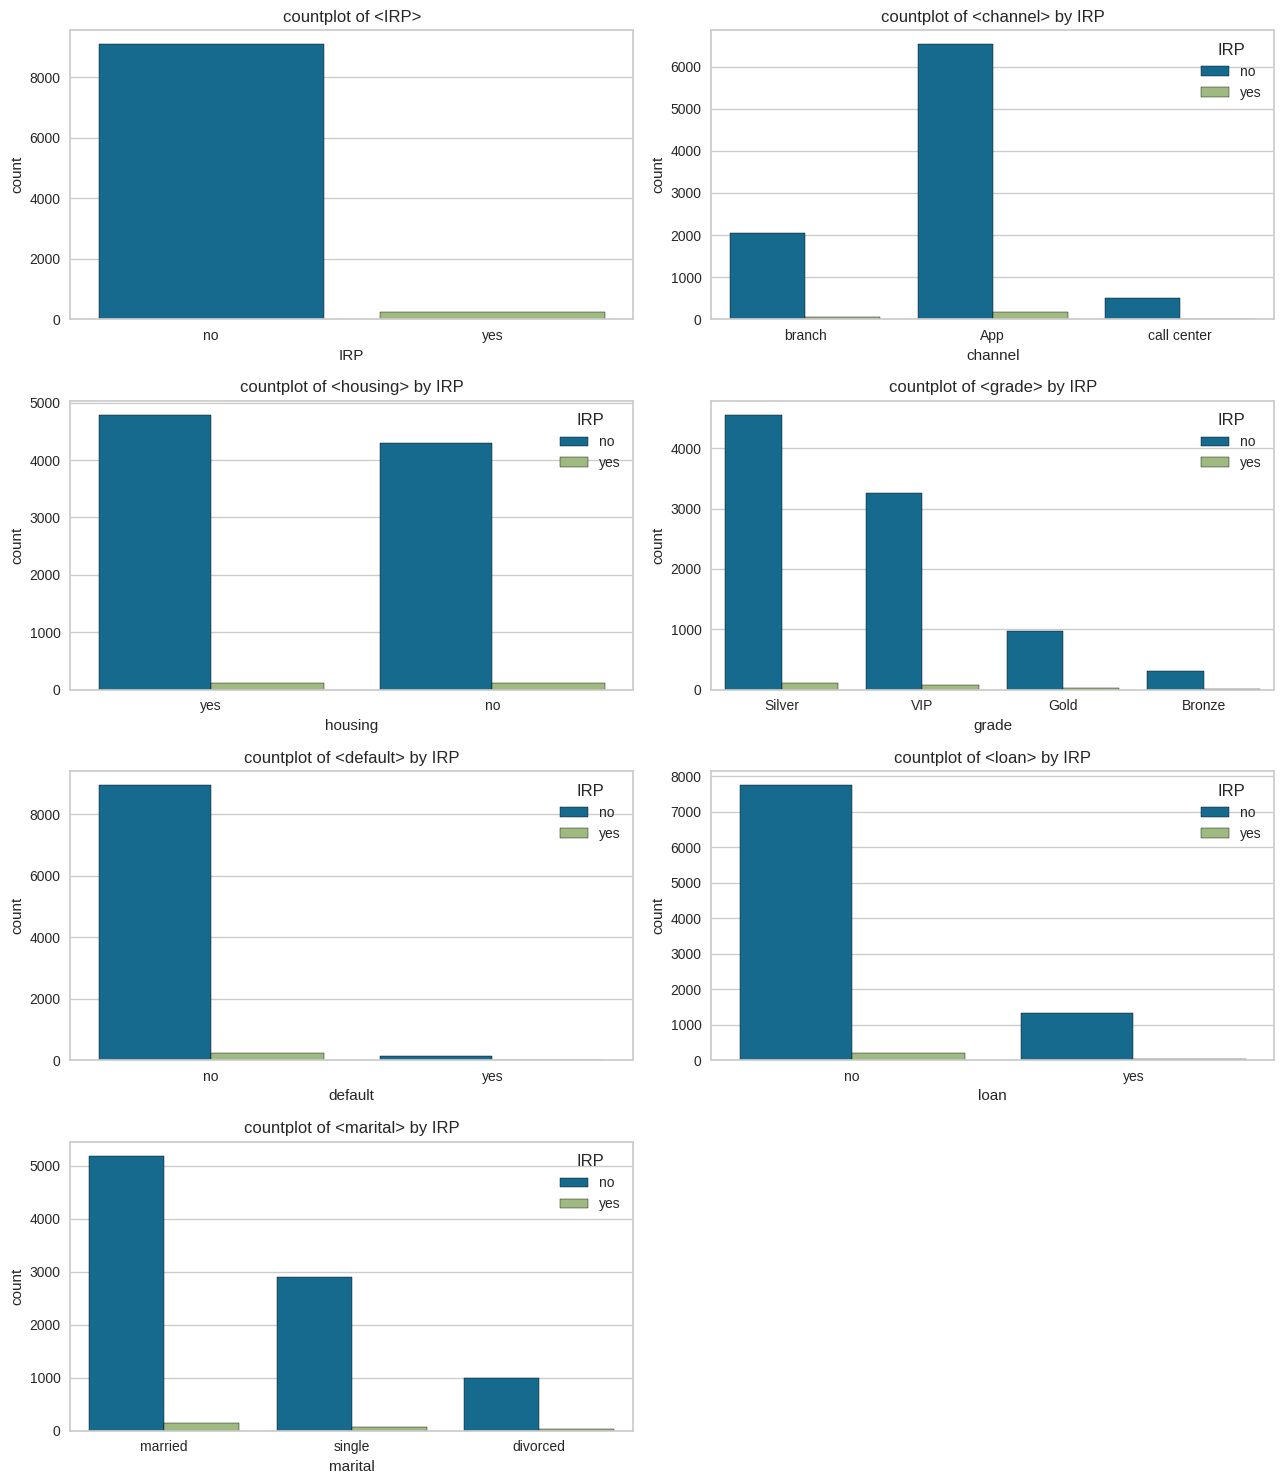

In [ ]:
# subplot으로 볼거 8개, 따로 볼거 2개
size = (13, 15)
height = 4
width = 2
target_col = 'IRP'
# other_cols = ['job', 'month']
other_cols = ['job']
subplot_cols = list(set(df[cate_feat]) - set(other_cols)) # list는 차집합이 안됨

draw_cate_feat(size, height, width, subplot_cols, target_col, df)

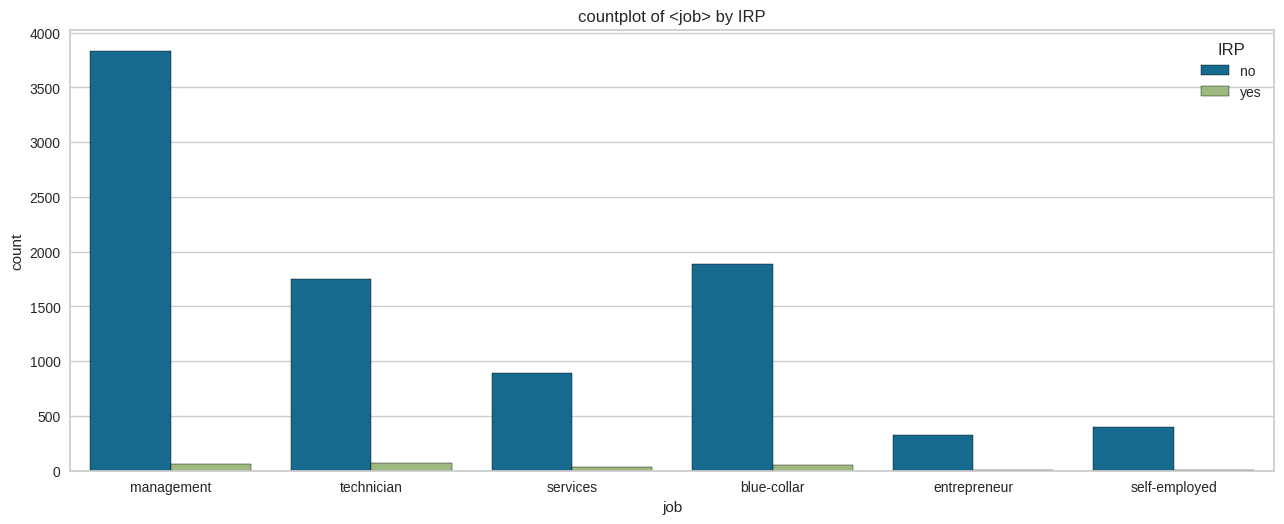

In [ ]:
size = (13, 10)
height = 2
width = 1
target_col = 'IRP'
subplot_cols = other_cols

draw_cate_feat(size, height, width, subplot_cols, target_col, df)

In [ ]:
fig=px.pie(df.channel.value_counts().reset_index().rename(columns={'index':'channel','channel':'Count'}),names='channel',values='Count',hole=0.5,template='simple_white')
fig.update_traces(marker=dict(line=dict(color='#000000', width=1.4)))
fig.update_layout(title_x=0.5,showlegend=True,legend_title_text='<b>channel')
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(title_x=0.5,legend=dict(orientation='h',yanchor='bottom',y=1.02,xanchor='right',x=1))
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

In [ ]:
a=df.groupby(['job','IRP'],as_index=False)['age'].count().rename(columns={'age':'Count'})
a['percent']=round(a['Count']*100/a.groupby('job')['Count'].transform('sum'),1)
a['percent']=a['percent'].apply(lambda x: '{}%'.format(x))
fig=px.bar(a,x='job',y='Count',text='percent',color='IRP',barmode='group',template='simple_white',color_discrete_sequence=['MediumPurple','YellowGreen'])
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)),textposition = "outside")
fig.update_layout(title_x=0.5,template='simple_white',showlegend=True,title_text='<b style="color:black; font-size:105%;">IRP based on Job Type</b>',font_family="Times New Roman",title_font_family="Times New Roman")
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

In [ ]:
fig=px.treemap(df.groupby(['job','IRP'],as_index=False)['age'].count().rename(columns={'age':'Count'}),path=['job','IRP','Count'],template='simple_white')
fig.update_layout(title_x=0.5,template='simple_white',title_text='<b style="color:black; font-size:100%;">Treemap on count of clients who subscribed the IRP or not based on Job',font_family="Times New Roman",title_font_family="Times New Roman")
fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

## 수치형 변수 처리

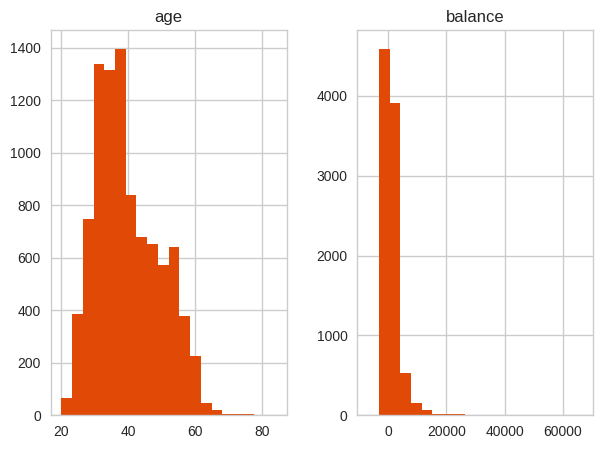

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

df.hist(bins=20, figsize=(7,5), color='#E14906')
plt.show()

In [ ]:
fig=px.line(df.groupby(['age','IRP'],as_index=False)['job'].count().rename(columns={'job':'Count'}),x='age',y='Count',color='IRP',template='simple_white',color_discrete_sequence=['DarkBlue','ForestGreen'])
fig.update_layout(title_x=0.08,font_family="Times New Roman",legend_title_text="<b> IRP",title_text='<b style="font-family: Times New Roman; font-size:1.3vw">Effect of Age on  IRPs')
fig.add_annotation(
  x=55,  # arrows' head
  y=165,  # arrows' head
  ax=60,  # arrows' tail
  ay=200,  # arrows' tail
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
  text='Even <b style="color: Brown;">mid-age group</b> clients <b style="color: green;">subscribed</b> more for the  IRPs,<br>     there is a more domination of clients from this group who are <br><b style="color: red;">not subscribed</b> for the <b style="color: Indigo;"> IRPs</b>.',  # if you want only the arrow
  showarrow=True,
  arrowhead=3,
  arrowsize=1,
  arrowwidth=1,
  arrowcolor='black'
)
fig.add_annotation(
  x=75,  # arrows' head
  y=30,  # arrows' head
  ax=80,  # arrows' tail
  ay=65,  # arrows' tail
  xref='x',
  yref='y',
  axref='x',
  ayref='y',
  text='<b style="color: Brown;">old age group</b> clients are <b style="color: Green;">subscribing</b> the <b style="color: Indigo;"> IRPs</b> more<br> and count of <b style="color: red;">not subscribing</b> to the IRPs is <b style="color: Green;">less</b>.',  # if you want only the arrow
  showarrow=True,
  arrowhead=3,
  arrowsize=1,
  arrowwidth=1,
  arrowcolor='black'
)
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

### 이상치 제거

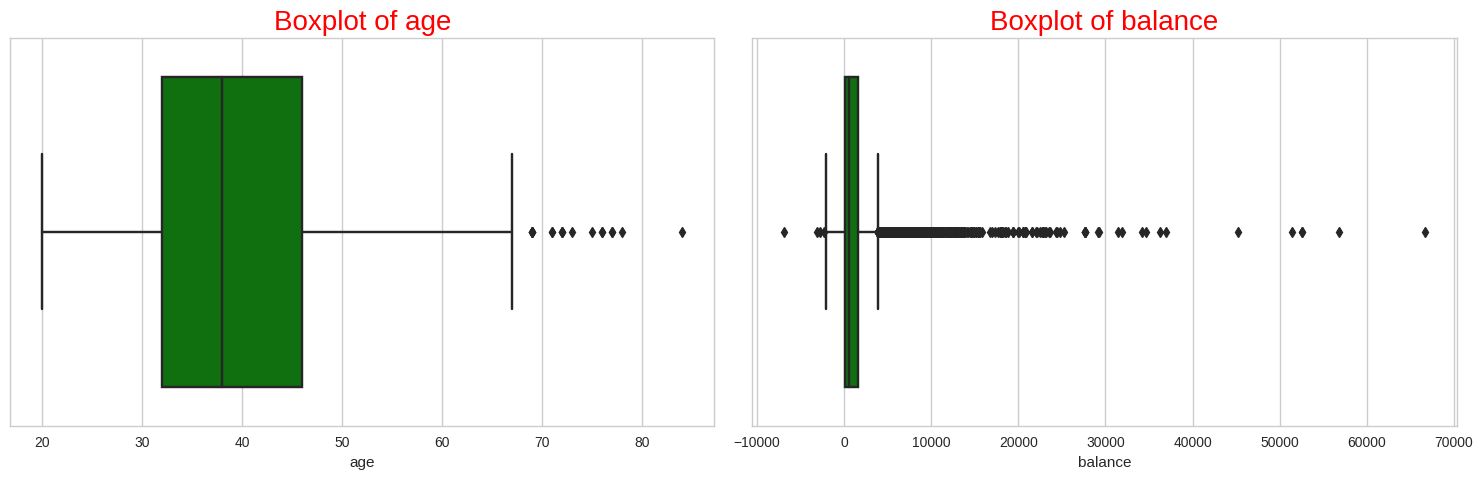

In [ ]:
# 이상치 파악 => 무지성으로 지우는건 아님. 분석을 통한 판단으로 지워야 하는데.. kmeans는 이상치 영향 많이 받긴한다
plt.figure(figsize=(15,18))
for i, col in enumerate(con_feat) :
    plt.subplot(4,2,i+1)
    sns.boxplot(x=col, data=df[con_feat], color='green')
    plt.title(f"Boxplot of {col}",size=20,color="red")
plt.tight_layout()
plt.show()

In [ ]:
def compare_boxplot(col):
    fig=px.box(df,x='IRP',y=col,color='IRP',template='simple_white',color_discrete_sequence=['YellowGreen','LightCoral'],title=f'<b>Effect of {col} on IRP Status')
    fig.update_layout(title_x=0.5,font_family="Times New Roman",legend_title_text="<b>IRP")
    fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

In [ ]:
for feat in con_feat :
    compare_boxplot(feat)

> - 위 결과에 따라서 각 변수가 IRP에 영향을 주는게 차이가 없는 것으로 판단되어 이상치 제거를 해도 될 것으로 결정.
> - 데이터셋 변경 후 이거는 좀 다시 손봐야 될 듯

In [ ]:
# 이상치 제거 : IQR
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers

Outliers_to_drop = detect_outliers(df, 2, con_feat)

In [ ]:
df.loc[Outliers_to_drop]

,age,job,marital,grade,default,balance,housing,loan,channel,IRP


In [ ]:
df = df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
df

,age,job,marital,grade,default,balance,housing,loan,channel,IRP
0,59,management,married,Silver,no,2343,yes,no,branch,no
1,56,management,married,Silver,no,45,no,no,branch,no
2,41,technician,married,Silver,no,1270,yes,no,branch,no
3,55,services,married,Silver,no,2476,yes,no,branch,no
4,54,management,married,VIP,no,184,no,no,branch,no
...,...,...,...,...,...,...,...,...,...,...
9318,33,blue-collar,single,Gold,no,1,yes,no,App,no
9319,39,services,married,Silver,no,733,no,no,branch,no
9320,32,technician,single,Silver,no,29,no,no,App,no
9321,43,technician,married,Silver,no,0,no,yes,App,no


In [ ]:
'''Skewness(비대칭도)란 분포가 얼마나 비대칭을 띄는가 알려주는 척도입니다.
(비대칭도: a=0이면 정규분포, a<0 이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침)
Kurtosis (첨도)란 확률분포의 뾰족한 정도를 나타내는 척도입니다.
관측치들이 어느 정도 집중적으로 중심에 몰려 있는가를 측정할 때 사용됩니다.'''

for col in con_feat :
  print('{:15}'.format(col), 'Skewness : {:05.2f}'.format(df[col].skew()), '    ', 'Kurtosis:{:05.2f}'.format(df[col].kurt()))

age             Skewness : 00.55      Kurtosis:-0.43
balance         Skewness : 06.93      Kurtosis:85.16


## 군집화

### 인코딩

In [ ]:
cate_feat

['job', 'marital', 'grade', 'default', 'housing', 'loan', 'channel', 'IRP']

In [ ]:
# 값 특성 상 데이터간 관계가 없으므로 LabelEncoder가 아닌 OH이용
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)
df_encoded = pd.get_dummies(df, columns=cate_feat ,dummy_na=True)
df_encoded

,age,balance,job_blue-collar,job_entrepreneur,job_management,job_self-employed,job_services,job_technician,job_nan,marital_divorced,...,loan_no,loan_yes,loan_nan,channel_App,channel_branch,channel_call center,channel_nan,IRP_no,IRP_yes,IRP_nan
0,59,2343,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,56,45,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
2,41,1270,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
3,55,2476,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4,54,184,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9318,33,1,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
9319,39,733,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
9320,32,29,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
9321,43,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0


### 정규화
- 변수별 값 범위가 다르므로

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_encoded_sc = scaler.fit_transform(df_encoded)

### 차원축소
- 모델에 넣기 전 현재 피쳐의 수가 꽤 많은편입니다 수가 많을수록 모델이 성능이 내기 어려워집니다

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(df_encoded_sc)
df_for_clustering = pd.DataFrame(pca.transform(df_encoded_sc), columns=(["col1","col2", "col3"]))
df_for_clustering.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,9323.0,-9.755387e-17,1.742443,-3.686981,-1.256681,-0.026200,1.311595,5.139872
col2,9323.0,-1.127967e-16,1.481899,-4.920326,-1.087251,0.043736,1.125929,5.170654
col3,9323.0,4.420410e-17,1.466969,-3.129516,-0.903507,-0.356943,0.297611,10.427560


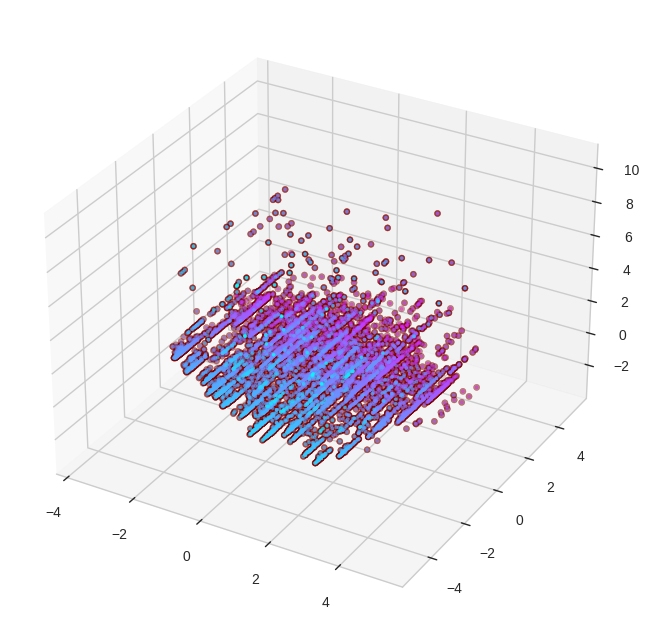

In [ ]:
#A 3D Projection Of Data In The Reduced Dimension
x = df_for_clustering["col1"]
y = df_for_clustering["col2"]
z = df_for_clustering["col3"]
#To plot
from matplotlib import cm
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
p3d = ax.scatter(x, y, z, s=5, c=y, cmap = cm.cool)
plt.show()

### 군집 수 정하기
- 위에서의 전처리 과정 (이상치 제거, 범주형 데이터 처리, 정규화, 차원축소) 을 거쳐 군집화 단계를 진행합니다
- KMeans 기반 모델에서는 군집 수 (K) 선정의 이슈가 있습니다. 이를 Elbow Method, Silhouette Score 등을 통해 최적 K를 산정하기로 합니다
- 기존 KMeans에서 단점을 보완한 K-Means ++ 모델을 사용합니다

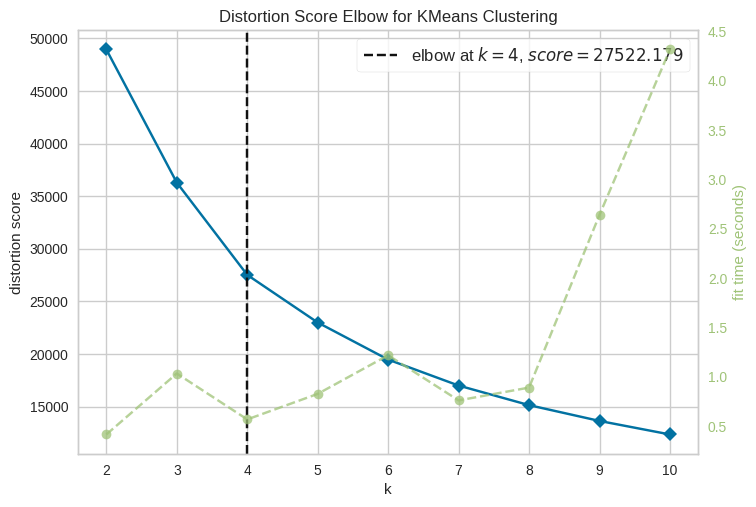

optimal_K : 4


In [ ]:
from yellowbrick.cluster import KElbowVisualizer

def plot_Elbow(df):
    Elbow_M = KElbowVisualizer(KMeans(), k=10)
    Elbow_M.fit(df)
    Elbow_M.show()
    optimal_K = Elbow_M.elbow_value_
    return optimal_K

optimal_K = plot_Elbow(df_for_clustering)
print(f'optimal_K : {optimal_K}')

- 위와 같이 비교적 구현하기 쉬운 Elbow Method를 통해 K 값을 구할 수도 있지만,
- 비교적 시간이 걸리더라도 보다 정확한 결과를 얻기위해 Silhouette score를 활용한 방식을 채택하였습니다

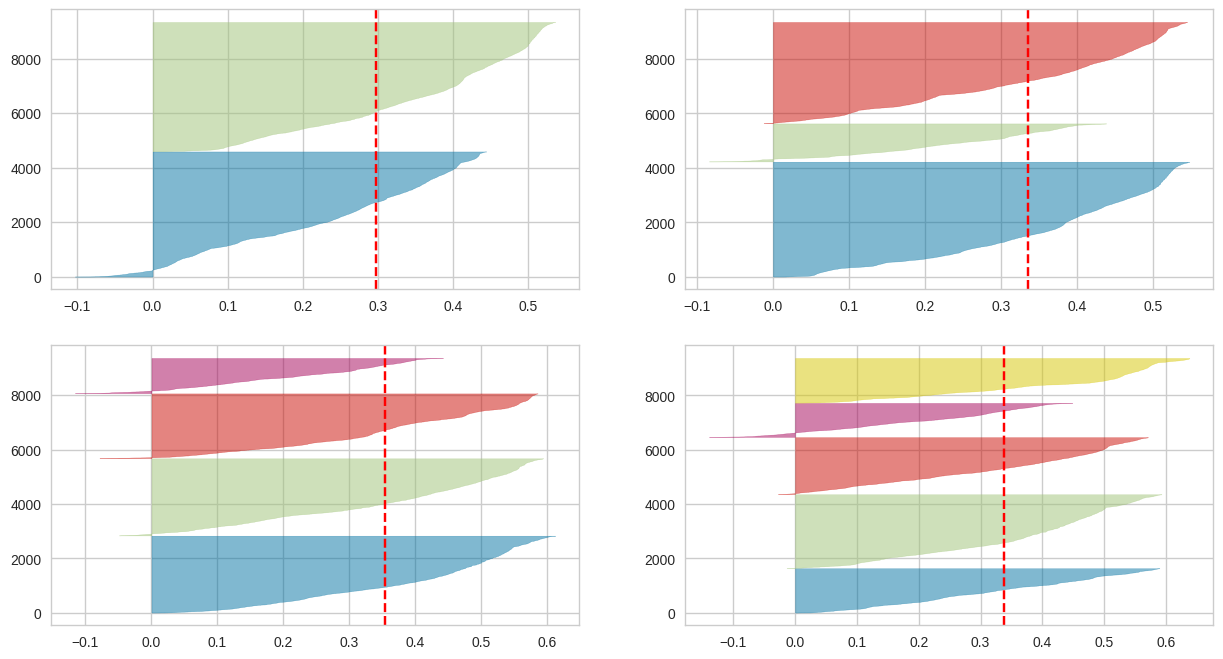

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

def plot_Silhouette(df):

    fig, ax = plt.subplots(2, 2, figsize=(15,8))
    for i in range(2,6) :
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42) # n_cluster가 아니라 n_cluster임
        q, mod = divmod(i, 2)
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
        visualizer.fit(df)

plot_Silhouette(df_for_clustering)

> - 각 군집의 실루엣 점수가 평균을 넘으면서 , 두께가 서로 유사한 경우를 K 값으로 채택하였습니다

In [ ]:
random_state = 15

# 위에서 구한 k를 바탕으로 기존 데이터프레임에 군집값을 넣음
def clustering(optimal_k, df_for_clustering, df_origin):
    km = KMeans(n_clusters=optimal_k, init='k-means++', random_state=random_state).fit(df_for_clustering)
    yhat_cluster = km.predict(df_for_clustering)
    df_for_clustering['cluster'] = yhat_cluster
    df_origin['cluster'] = yhat_cluster + 1

clustering(optimal_K, df_for_clustering, df)

In [ ]:
df.head()

,age,job,marital,grade,default,balance,housing,loan,channel,IRP,cluster
0,59,management,married,Silver,no,2343,yes,no,branch,no,2
1,56,management,married,Silver,no,45,no,no,branch,no,4
2,41,technician,married,Silver,no,1270,yes,no,branch,no,2
3,55,services,married,Silver,no,2476,yes,no,branch,no,2
4,54,management,married,VIP,no,184,no,no,branch,no,4


In [ ]:
df.to_csv(data_path +'clustering_result.csv', encoding='utf-8')


### 군집화 결과

#### pca 결과

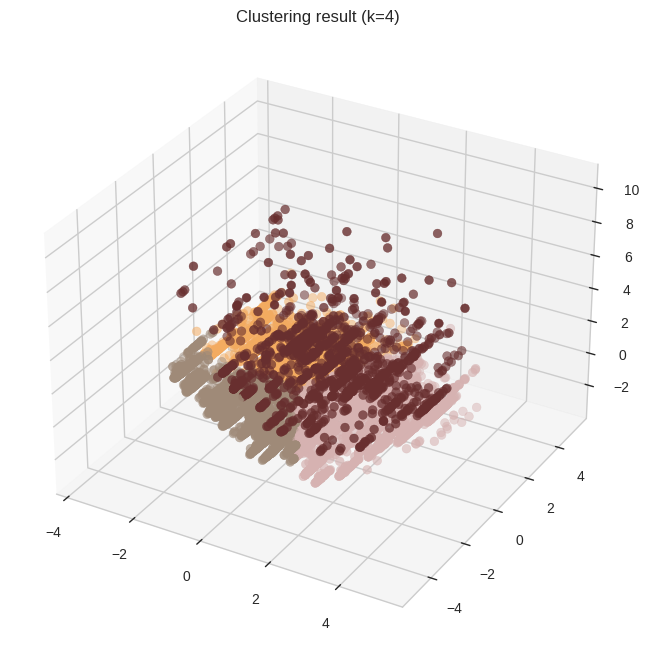

In [ ]:
from matplotlib import colors

pal = ["#d7191c","#fdae61", "#abdda4", "#2b83ba"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# 군집결과 확인하기 (1) : pca 결과 확인
def distribution_cluster_pca(df_for_cluster, optimal_K) :
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(111, projection='3d', label="bla")
    x = df_for_cluster["col1"]
    y = df_for_cluster["col2"]
    z = df_for_cluster["col3"]
    ax.scatter(x, y, z, s=40, c=df_for_cluster["cluster"], marker='o', cmap = cmap )
    ax.set_title(f"Clustering result (k={optimal_K})")
    plt.show()

distribution_cluster_pca(df_for_clustering, optimal_K)

#### 군집 별 결과

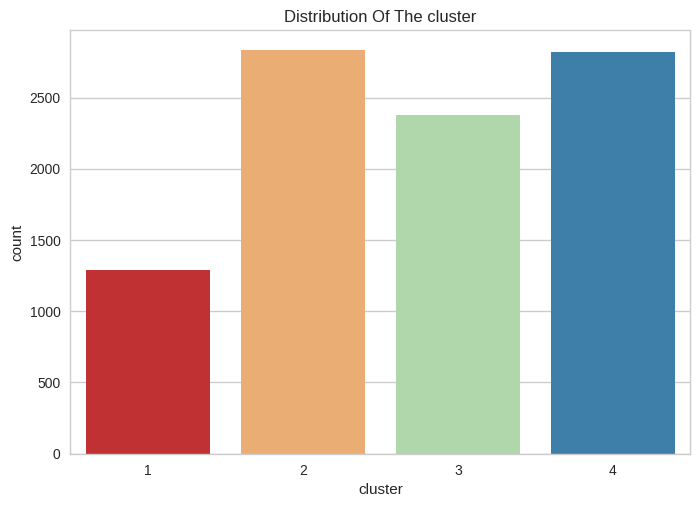

In [ ]:
# 군집결과 확인하기 (2) : 기존 데이터프레임에서의 군집 분포 확인
def show_distribution_cluster(df) :
    pl = sns.countplot(x=df["cluster"], palette= pal)
    pl.set_title("Distribution Of The cluster")
    plt.show()

show_distribution_cluster(df)

> 군집별로 어디에 치중되지 않고 고루 나옴

In [ ]:
def plot_catefeats_by_cluster(df, optimal_K, feature_list): # 범주형 분석

  fig, axes = plt.subplots(nrows=optimal_K, ncols=len(feature_list),figsize=(50, 10))
  plt.subplots_adjust(wspace=0.3, hspace = 0.5)
  maximum_kind = 5
  pie_constant = 4
  angular = 15
  title_size = 10
  pie_size = 7

  for cluster_num in range(1, optimal_K+1): # 1번군집부터 마지막 군집까지 군집별로 그림을 그려준다
    for idx, feature in enumerate(feature_list):
        if df[feature].nunique() > pie_constant : # 피쳐 값 종류가 설정한 pie 상수보다 더 많으면 countplot으로 그린다
            plot = sns.countplot(x=feature, data=df.loc[df['cluster'] == cluster_num],
                                order = df.loc[df['cluster'] == cluster_num][feature].value_counts().iloc[:maximum_kind].index[::-1], ax=axes[cluster_num-1, idx])
            if feature == 'job' : # rotate 필요한거에 한해서만
                plot.set_xticklabels(plot.get_xticklabels(), rotation=angular)
            title = f'cluster_{cluster_num} "{feature}"'
            plot.set_title(title, fontsize=title_size, weight='bold')
            plot.set_xlabel(' ')
            plot.set_ylabel(' ')

        else : # pie chart로 표현하는 경우
            data = df.loc[df['cluster'] == cluster_num][feature].value_counts().values.tolist()
            labels = df.loc[df['cluster'] == cluster_num][feature].value_counts().index.tolist()
            explode = (0.1,) * len(labels)
            colors = sns.color_palette('pastel')[0:len(labels)]
            ax = axes[cluster_num-1, idx]
            ax.pie(data, explode=explode, labels = labels, autopct='%.0f%%', shadow = True, startangle = 90, textprops={'fontsize': pie_size})
            ax.axis('equal')
            ax.set_title(f'cluster_{cluster_num} "{feature}"')

  plt.show()

In [ ]:
def plot_confeats_by_cluster(df, name_list): # 연속형 : 군집별 평균 값을 산출하는거라 군집 수를 받을 필요가 없음

  fig, axes = plt.subplots(1,len(name_list),figsize=(20, 5))
  plt.subplots_adjust(wspace=0.3, hspace = 0.5)

  for idx in range(len(name_list)):

    plot = sns.barplot(x=name_list[idx], y = 'cluster', data=df, orient='h', ci=None , ax=axes[idx])
    title = f'Average "{name_list[idx]}" by cluster'
    plot.set_title(title, fontsize=10, weight='bold')
    plot.set_xlabel(' ')
    plot.set_ylabel('cluster')

  plt.show()

- fig, axes = plt.subplots(optimal_K,len(feature_list),figsize=(50, 10))
    - 군집 수, 피쳐 수 만큼의 그래프를 먼저 그려주는 것임.
    - https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=heygun&logNo=221520454294

In [ ]:
# irp 전체구성 비율
fig=px.pie(df.IRP.value_counts().reset_index().rename(columns={'index':'IRP','IRP':'Count'}),names='IRP',values='Count',hole=0.5,template='simple_white')
fig.update_traces(marker=dict(line=dict(color='#000000', width=1.4)))
fig.update_layout(title_x=0.5,showlegend=True,legend_title_text='<b>IRP')
fig.update_traces(textposition='outside', textinfo='percent+label')
fig.update_layout(title_x=0.5,legend=dict(orientation='h',yanchor='bottom',y=1.02,xanchor='right',x=1))
fig.show(renderer="colab") # 이걸해줘야 colab에서도 plotly가 바로 보임

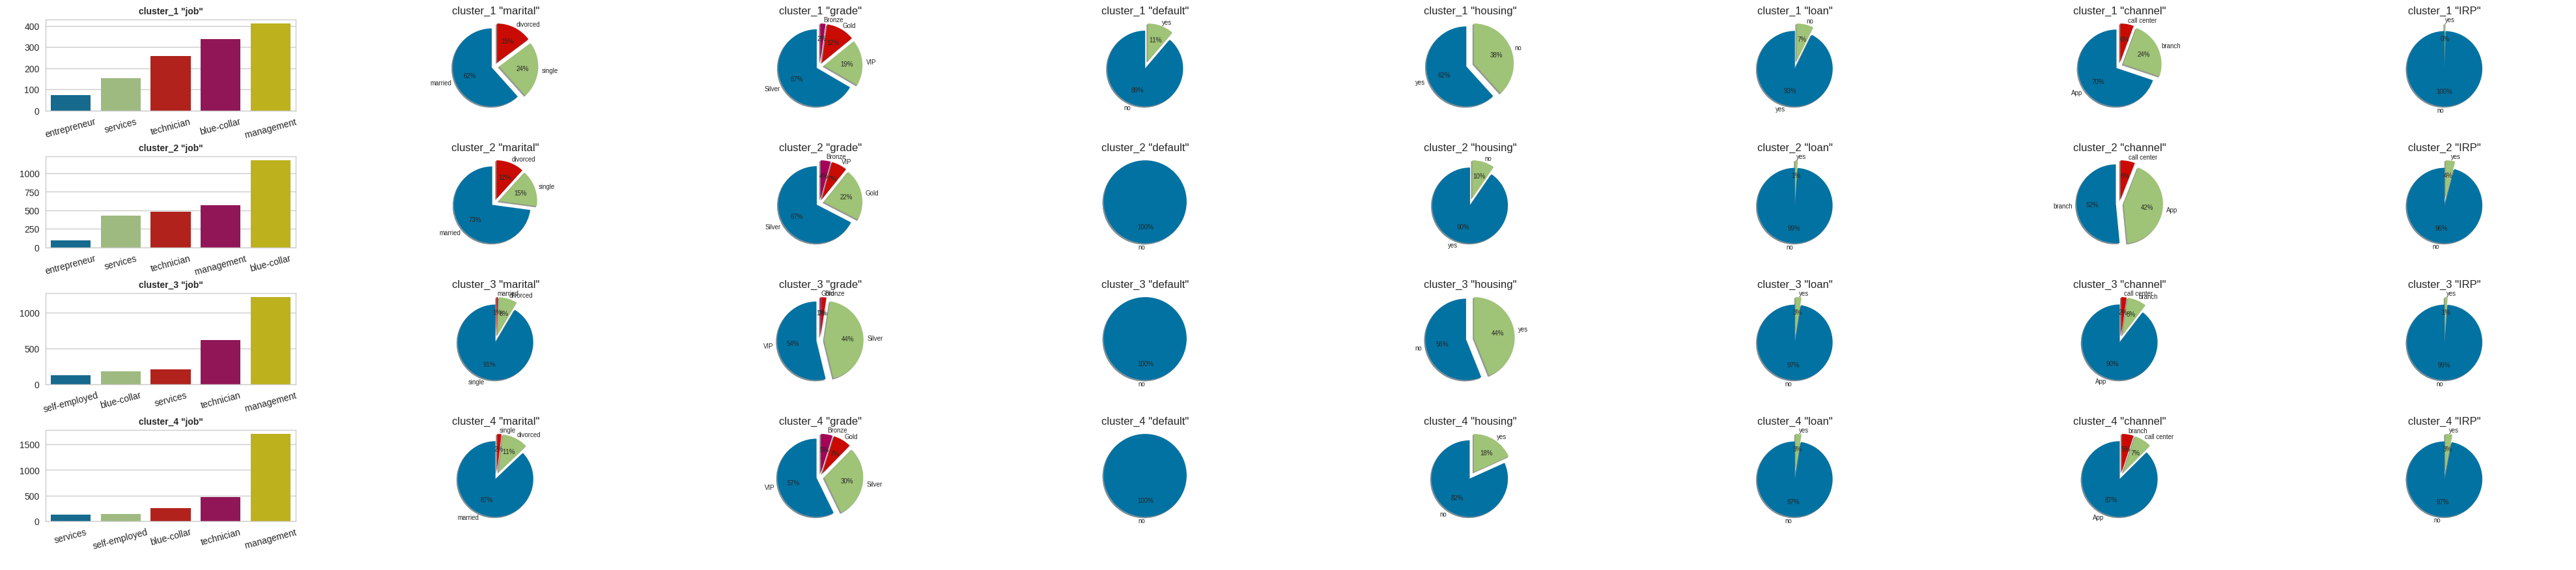

In [ ]:
plot_catefeats_by_cluster(df, optimal_K, cate_feat)

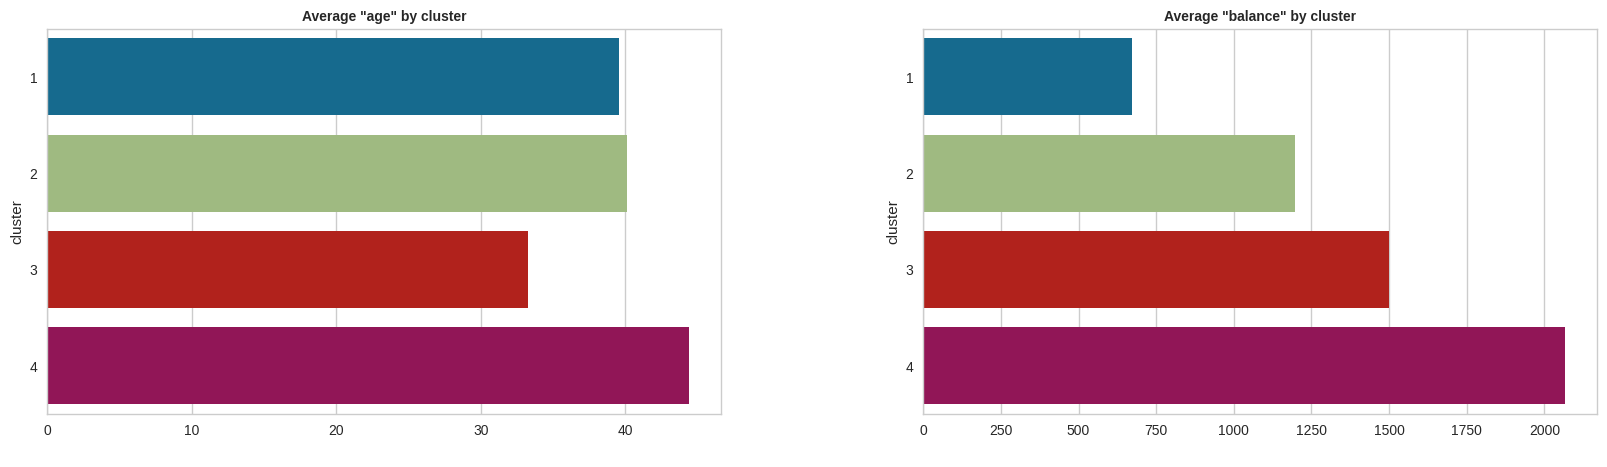

In [ ]:
plot_confeats_by_cluster(df, con_feat)

In [ ]:
df.iloc[:,:-1].describe()

,age,balance
count,9323.000000,9323.000000
mean,39.581465,1465.277164
std,9.533356,3041.737711
min,20.000000,-6847.000000
25%,32.000000,111.000000
50%,38.000000,520.000000
75%,46.000000,1612.000000
max,84.000000,66653.000000


## 결과


        - vip : 총예금평잔, 총대출평잔, 외환실적 일정금액 이상 경우
        - gold : 주거래이체여부(급여, 공과금, 국민카드), 당행 상품보유 여부 등
        - silver : kb어플 이용여부, 오픈뱅킹, 마이데이터 서비스 여부 등
        - bronze : 생애최초거래자, 비실거래손님집단

- 유형1 고객군 : **"잔액이 가장적으며 신용대출 이용 비율이 많은 고객군"**
    - 사무직, 현장직이 유사한 비율로 가장 많음
    - 다수가 기혼, 일부는 이혼경험 있음
    - **나이는 평균이지만 잔액이 가장 적은** 집단
    - silver 70, vip 20, gold 10 의 고객등급 구성
    - **신용불량이 유일하게 해당 군집의 11%로 존재**
    - 주택담보대출 보유비율 절반 조금넘으며, **타고객군과 다르게 신용대출을 보유하는 경우가 대부분인 집단**
    - 어플 2 영업점1 비율. **영업점 내점 비율도 두번째로 많은** 집단
    - 현 데이터 상으로는 **irp 가입 경우가 0%로 가입확률이 가장낮은** 집단.
> - 신용대출 이용 비율이 높은 고객군으로, 신용도 향상을 위해 신용카드 권유 및 대출금리 감면을 위한 부수거래를 권유하기 좋음    
> - 잔액이 가장 적고, irp 가입 확률도 가장 낮은 집단으로 무리한 노후상품 권유보다는 (급여, 공과금)과 같은 주거래이체 권유 등을 통해 향후 장기간 충성고객으로의 변화를 기대해보는 점이 더 좋음

- 유형2 고객군 : **"영업점 내점 빈도가 가장 많고, irp 가입 확률이 제일 높은 집단"**
    - **현장 근로직이 가장 많은 비율**을 차지하는 집단
    - 다수가 기혼, 일부는 이혼경험 있음
    - **나이와 잔액이 모두 평균** 정도의 집단
    - silver 70, gold 20, vip 10의 고객등급 구성
    - 신용이 전혀 문제 없는 군집
    - 주택담보대출 대부분 O, 신용대출 대부분 X
    - 영업점, 어플 비율이 유사하게 1대1수준으로, **영업점 내점 비율이 52%로, 영업점 내점 비율이 가장 많은 집단**
    - **irp 가입 비율이 4프로로 전체평균보다 2배 높은 집단**
> - 은행 업무를 영업점에 내점하여 처리하는 경우가 많음. irp 가입 비율도 현재 가장 높은 고객군으로, 내점 시 적금과의 비교 등을 통해 가입 권유를 해보는 것이 좋음.
> - 또한 silver 등급이 가장 많은 손님으로 앞으로의 주거래이체 권유 등을 통해 향후 장기간 충성고객 층으로 변화를 기대해볼 수 있음.

- 유형3 고객군 : **"평균 연령과 잔액이 가장 높으며 대출이 없고 vip 비율 가장 높은 집단"**
    - 사무직 대부분
    - 90프로 가까이 **대부분 기혼**
    - 평균연령이 40 이상으로, **연령과 잔액이 모두 가장 높은 집단**
    - vip 절반, silver 절반 (도합 88%), **vip 비율이 제일 많은 집단**
    - 신용이 전혀 문제 없는 군집
    - 주택담보대출, 신용대출 **모두 보유하지 않는 경우가 다수인 집단**
    - 어플이용 비율이 대다수
    - irp 가입 비율이 3프로로 **전체평균에 비해 근소하게 높은** 집단
> - 잔액 가 가장 많으며 대출은 없는 기혼 집단으로 자금 상태가 안정적이며 평균 연령대가 높은 vip 집단.
> - 향후 앞으로의 노후준비를 위한 퇴직연금 상품 가입을 권유하기 가장 좋음. irp, 펀드와 같은 장기자금관리 상품가입 권유를 통해 vip 이탈을 막는데 집중할 필요가 있음.     

- 유형4 고객군 : **"평균 연령은 가장 낮지만 잔액과 어플 사용빈도는 가장 많은 미혼 집단"**
    - 사무직 대부분
    - 90프로 넘는 비율로 **대부분 미혼**
    - 평균연령은 **가장 어리지만, 잔액은 두번재로 높은** 집단
    - vip 절반, silver 절반(도합 98% : 극단적인 2개 등급으로 구성된 고객군), 이외가 없는게 특징, **vip 비율이 제일 많은 집단**
    - 신용이 전혀 문제 없는 군집
    - 주택담보대출은 없는 경우가 조금 더 많으며 신용대출은 대부분은 없음
    - 어플이용 비율이 대다수
    - irp 가입 비율 1프로, 전체 가입비율의 **절반수준으로 가입 확률이 낮음**
> - 나이에 비해 현재 잔액은 높은 vip가 많은 고객군.
> - 나이는 젊은 편이며 어플이용 비율이 가장 높은편으로, 모바일을 통해 자금관리현황을 바로 확인 할 수 있는 방카/ETF/펀드 등의 상품을 다양하게 권유하기 좋음
> - vip와 silver 2개 등급으로 구성된 비율로 vip는 이탈방지에, silver는 향후 충성고객층으로의 관리에 집중할 필요가 있음

## 추가) Feature importance
- simple Random Forest to get feature importances
- I referenced here : https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

In [ ]:
df = df.iloc[:,:-1]

def change_IRP(x):
    if x == 'no' :
        x = 0
    else :
        x = 1
    return x

df['IRP'] = df['IRP'].apply(change_IRP)
df.head()

,age,job,marital,grade,default,balance,housing,loan,channel,IRP
0,59,management,married,Silver,no,2343,yes,no,branch,0
1,56,management,married,Silver,no,45,no,no,branch,0
2,41,technician,married,Silver,no,1270,yes,no,branch,0
3,55,services,married,Silver,no,2476,yes,no,branch,0
4,54,management,married,VIP,no,184,no,no,branch,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

target = df[['IRP']]
data = df.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target, random_state=42)

In [ ]:
data

,age,job,marital,grade,default,balance,housing,loan,channel
0,59,management,married,Silver,no,2343,yes,no,branch
1,56,management,married,Silver,no,45,no,no,branch
2,41,technician,married,Silver,no,1270,yes,no,branch
3,55,services,married,Silver,no,2476,yes,no,branch
4,54,management,married,VIP,no,184,no,no,branch
...,...,...,...,...,...,...,...,...,...
9318,33,blue-collar,single,Gold,no,1,yes,no,App
9319,39,services,married,Silver,no,733,no,no,branch
9320,32,technician,single,Silver,no,29,no,no,App
9321,43,technician,married,Silver,no,0,no,yes,App


In [ ]:
numerical_columns = ['age', 'balance']
categorical_columns = list(set(data.columns) - set(numerical_columns))

categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
)
numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train, y_train)

print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.998
RF test accuracy: 0.972


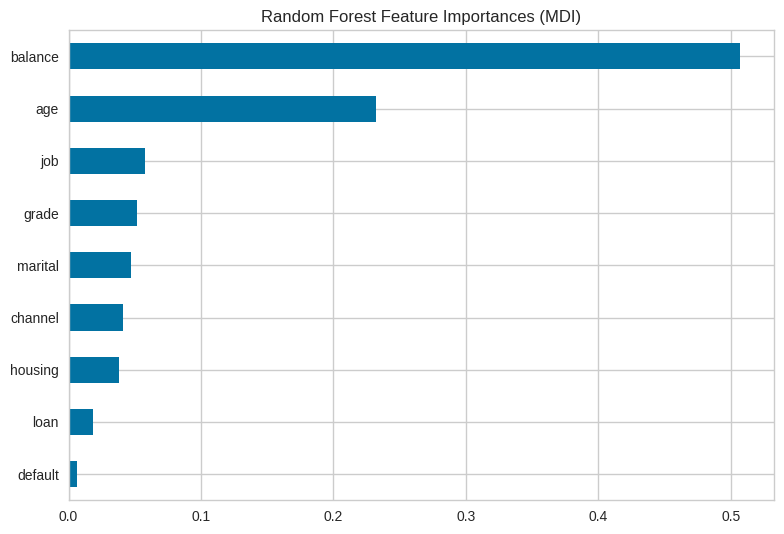

In [ ]:
import pandas as pd

feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    rf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

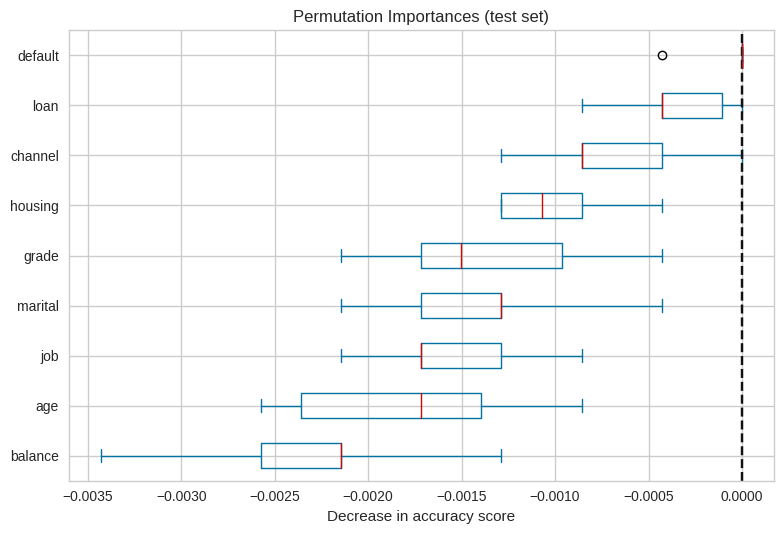

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=data.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

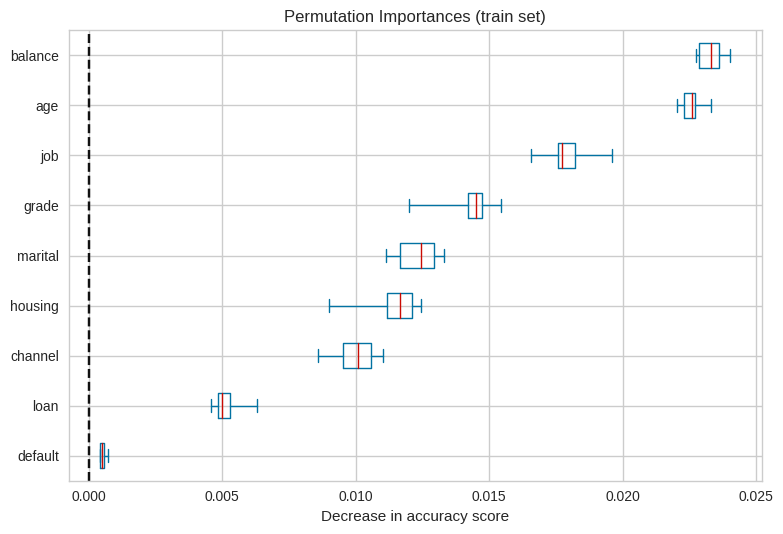

In [ ]:
result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=data.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()